# Восстановление золота из руды

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

Откроем фалы и изучим их

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv('gold_industry_train.csv')
df_test = pd.read_csv('gold_industry_test.csv')
df_full = pd.read_csv('gold_industry_full.csv')
df_train.info()
df_test.info()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


Видим что некоторые данные имеют пропуски 10-100 значений. Самое большое количество пропусков в secondary_cleaner.output.tail_sol , примерно 1900 пропусков. 

Дата везде указана как строка а все остальные числовые данные в float64

Колонок у нас в обучающей и полной выборке по 87, а в тестовой 53. В описании указано что это связано с тем что в тестовой выборке удалены целевые значения. 

In [3]:
df_full.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


Какие то данные находятся в рамках 1 , а какие то уходят за сотни, что говорит о дизбалансе для посторяения модели машинного обучения.

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака.

In [4]:
df_train['rougher.output.recovery'].head(5) # оценим исходные данные

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [5]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery = ((C*(F-T))/(F*(C-T)))*100
recovery.head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

In [6]:
mean_absolute_error(df_train['rougher.output.recovery'], recovery)

9.83758577644259e-15

Мы видим что значения эффективность обогащения рассчитанные нами вручную и данные в таблице практически не отличаются. МАЕ этих параметров стремится к нулю. 

Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

Мы видим что отсутсвуют output — параметры продукта, а так же final — финальные характеристики и calculation — расчётные характеристики. Исходя из описания мы знаем что это связано с тем что часть данных еще не получили, а чать отсутсвует намеренно. 

Если говорить о построении модели обучения, то упомянутые выше параметры могут быть "спойлерами" для обучающей модели. Для получения более чистой модели мы должны удалить колонки в обучающей выборке, которы могут подсказывать верные варианты которые являются финальными и выявляются как промежуточные итоги.

In [7]:
df_train = df_train.ffill(axis=0) # заполним пропуски методом ffill так как он заменяет пропуск значением предыдущей ячейки, что в случае с изменением вещества со временем является наиболее уместным методом
df_test = df_test.ffill(axis=0)
df_full = df_full.ffill(axis=0)
print(df_train.isna().sum())
print(df_test.isna().sum())
df_full.isna().sum()

date                      0
rougher.input.feed_au     0
rougher.input.feed_ag     0
rougher.input.feed_pb     0
rougher.input.feed_sol    0
                         ..
final.output.recovery     0
final.output.tail_au      0
final.output.tail_ag      0
final.output.tail_pb      0
final.output.tail_sol     0
Length: 87, dtype: int64
date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air            

date                      0
rougher.input.feed_au     0
rougher.input.feed_ag     0
rougher.input.feed_pb     0
rougher.input.feed_sol    0
                         ..
final.output.recovery     0
final.output.tail_au      0
final.output.tail_ag      0
final.output.tail_pb      0
final.output.tail_sol     0
Length: 87, dtype: int64

In [8]:
col_list = df_test.columns.tolist() # получили список колонок из тестовой выборки
df_train_1 = df_train.drop(col_list, axis=1) # удалили из тренировочной выборки колонки которые есть в тестовой
print(df_train_1.info()) # теперь мы можем убедиться еще раз что данные колонки являются спойлерами для обучения
col_list_difference = df_train_1.columns.tolist() # список отличающихся колонок тестовой и тренировочной выборки
df_train_new = df_train.drop(col_list_difference, axis=1) # удалим различающиеся колонки из тренировочной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       14579 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  14579 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  14579 non-null  float64
 3   rougher.calculation.au_pb_ratio                     14579 non-null  float64
 4   rougher.output.concentrate_au                       14579 non-null  float64
 5   rougher.output.concentrate_ag                       14579 non-null  float64
 6   rougher.output.concentrate_pb                       14579 non-null  float64
 7   rougher.output.concentrate_sol                      14579 non-null  float64
 8   rougher.output.recovery                             14579 non-null  float64


In [9]:
print(df_train_new.shape)
df_test.shape # количество колонок тестовой и тренировочной выборки совпадает

(14579, 53)


(4860, 53)

Предобработка закончена. Притупим к анализу

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Au:
 - rougher.input.feed_au - концентрация Au в сырье
 - rougher.output.concentrate_au - Au в черновом концентрате
 - primary_cleaner.output.concentrate_au - Au в концентрате после первой очистки
 - final.output.concentrate_au - Au в финальном концентрате
 
Ag:
 - rougher.input.feed_ag - концентрация Ag в сырье
 - rougher.output.concentrate_ag - Ag в черновом концентрате
 - primary_cleaner.output.concentrate_ag - Ag в концентрате после первой очистки
 - final.output.concentrate_ag - Ag в финальном концентрате

Pb:
 - rougher.input.feed_pb - концентрация Pb в сырье
 - rougher.output.concentrate_pb - Pb в черновом концентрате
 - primary_cleaner.output.concentrate_pb - Pb в концентрате после первой очистки
 - final.output.concentrate_pb - Pb в финальном концентрате

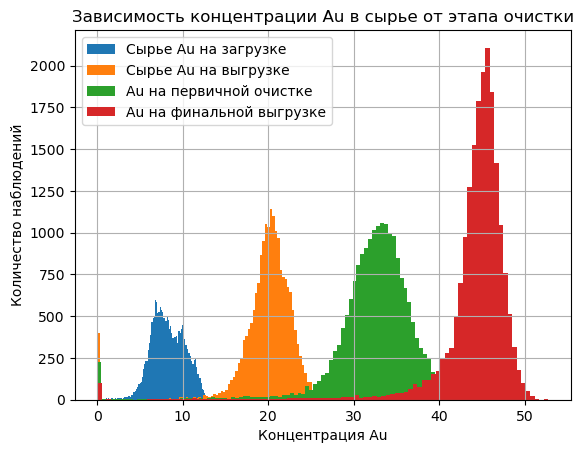

In [10]:
df_full['rougher.input.feed_au'].hist(bins=100,label='Сырье Au на загрузке')
df_full['rougher.output.concentrate_au'].hist(bins=100,label='Сырье Au на выгрузке')
df_full['primary_cleaner.output.concentrate_au'].hist(bins=100,label='Au на первичной очистке')
df_full['final.output.concentrate_au'].hist(bins=100,label='Au на финальной выгрузке')
plt.title('Зависимость концентрации Au в сырье от этапа очистки')
plt.xlabel('Концентрация Au')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

Гистограмма распределения наглядно показывает как меняется концентрация Au на различных этапах. С каждым последующим этапом очистки возрастает концентрация Au в сырье. Последний этап показывает наиболее наиболее сильное стремление к среднему значению. Так же отметим выбросы в 0 значении после певого этапа очистки и в финальном концентрате. 

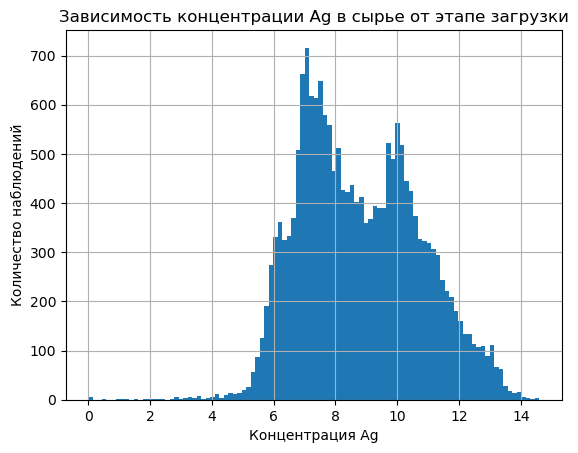

In [11]:
df_full['rougher.input.feed_ag'].hist(bins=100)
plt.title('Зависимость концентрации Ag в сырье от этапе загрузки')
plt.xlabel('Концентрация Ag')
plt.ylabel('Количество наблюдений')
plt.show()

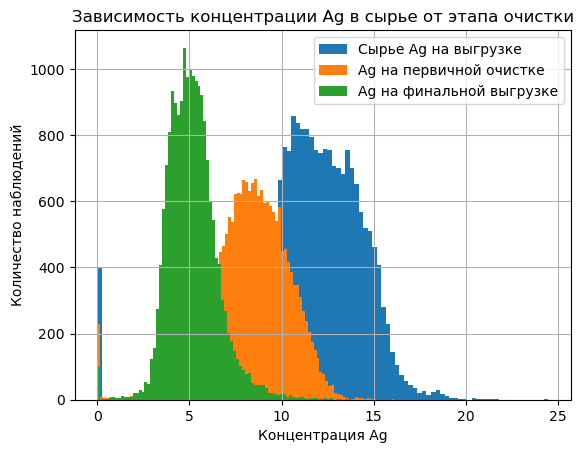

In [12]:
df_full['rougher.output.concentrate_ag'].hist(bins=100,label='Сырье Ag на выгрузке')
df_full['primary_cleaner.output.concentrate_ag'].hist(bins=100,label='Ag на первичной очистке')
df_full['final.output.concentrate_ag'].hist(bins=100,label='Ag на финальной выгрузке')
plt.title('Зависимость концентрации Ag в сырье от этапа очистки')
plt.xlabel('Концентрация Ag')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

In [13]:
print(df_full['rougher.input.feed_ag'].mean())
print(df_full['rougher.output.concentrate_ag'].mean())
print(df_full['primary_cleaner.output.concentrate_ag'].mean())
df_full['final.output.concentrate_ag'].mean()

8.794927425814688
11.994759359873429
8.442408077719058


5.1683869675102425

Гистограмма распределения наглядно показывает как меняется концентрация Ag на различных этапах. С каждым последующим этапом очистки меняется концентрация Ag в сырье. Последний этап показывает наиболее наиболее сильное стремление к среднему значению. Так же отметим выбросы в 0 значении на всех этапах очистки.

При изменении сырья в черновой концентрат значение концентрации увеличилось что может говорить об удалении значительной части пустой породы, дальше концентрация падает на всех этапах что говорит о уменьшении Ag для более чистого значения Au

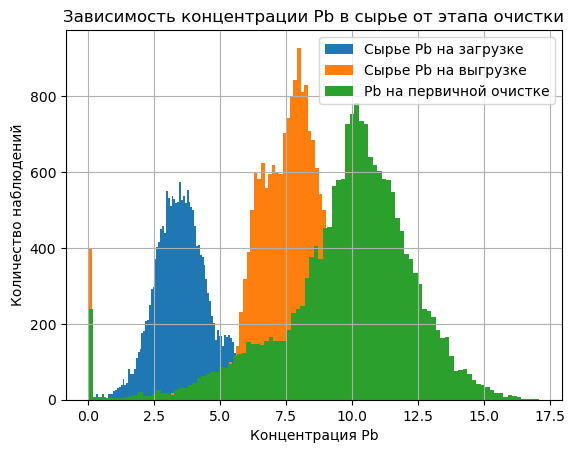

In [14]:
df_full['rougher.input.feed_pb'].hist(bins=100,label='Сырье Pb на загрузке')
df_full['rougher.output.concentrate_pb'].hist(bins=100,label='Сырье Pb на выгрузке')
df_full['primary_cleaner.output.concentrate_pb'].hist(bins=100,label='Pb на первичной очистке')
plt.title('Зависимость концентрации Pb в сырье от этапа очистки')
plt.xlabel('Концентрация Pb')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

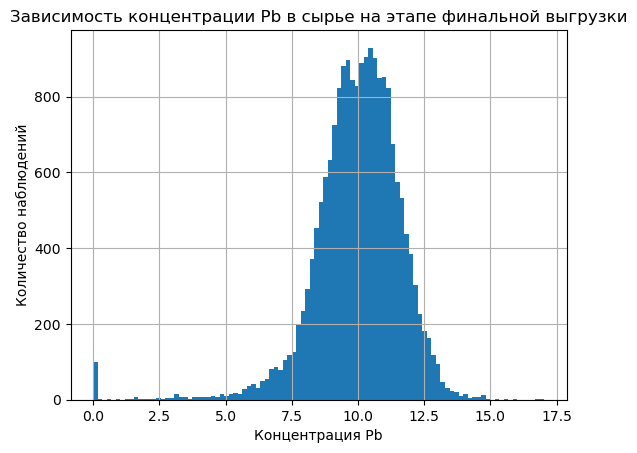

In [15]:
df_full['final.output.concentrate_pb'].hist(bins=100)
plt.title('Зависимость концентрации Pb в сырье на этапе финальной выгрузки')
plt.xlabel('Концентрация Pb')
plt.ylabel('Количество наблюдений')
plt.show()

Гистограмма распределения наглядно показывает как меняется концентрация Pb на различных этапах. С каждым последующим этапом очистки меняется концентрация Pb в сырье. Последний этап показывает наиболее наиболее сильное стремление к среднему значению. Так же отметим выбросы в 0 значении на всех этапах очистки.

С каждым этапом мы видим что увеличивается концентрация и увличивается стремление к среднему значению. 

### Сравним распределение размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

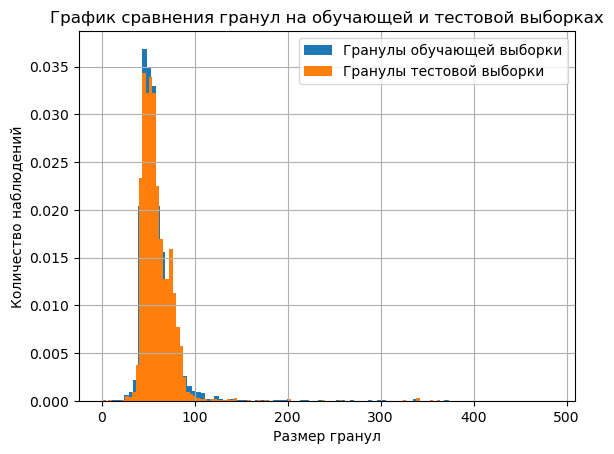

In [16]:
df_train['rougher.input.feed_size'].hist(bins=100,density=True,label='Гранулы обучающей выборки')
df_test['rougher.input.feed_size'].hist(bins=100,density=True,label='Гранулы тестовой выборки')
plt.title('График сравнения гранул на обучающей и тестовой выборках')
plt.xlabel('Размер гранул')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

In [17]:
print(df_test['rougher.input.feed_size'].describe())
df_train['rougher.input.feed_size'].describe()

count    4860.000000
mean       59.136150
std        19.512497
min         0.046369
25%        47.610795
50%        55.461058
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64


count    14579.000000
mean        59.070865
std         22.903811
min          0.049194
25%         47.322462
50%         54.464259
75%         64.469177
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Гистограмма и метод описания указывает нам на то что гранулы распределены очень похожи образом в тестовой и тренировочной выборке. Существенные значения мы наблюдаем только в максимальных значениях, которые являются выбросами.

### Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [18]:
df_full['rougher_input_sum'] = df_full['rougher.input.feed_au']+df_full['rougher.input.feed_ag']+df_full['rougher.input.feed_pb']
df_full['rougher_output_sum'] = df_full['rougher.output.concentrate_au']+df_full['rougher.output.concentrate_ag']+df_full['rougher.output.concentrate_pb']
df_full['primary_cleaner_sum'] = df_full['primary_cleaner.output.concentrate_au']+df_full['primary_cleaner.output.concentrate_ag']+df_full['primary_cleaner.output.concentrate_pb']
df_full['final_output_sum'] = df_full['final.output.concentrate_au']+df_full['final.output.concentrate_ag']+df_full['final.output.concentrate_pb']
df_train['rougher_input_sum'] = df_train['rougher.input.feed_au']+df_train['rougher.input.feed_ag']+df_train['rougher.input.feed_pb']
df_train['rougher_output_sum'] = df_train['rougher.output.concentrate_au']+df_train['rougher.output.concentrate_ag']+df_train['rougher.output.concentrate_pb']
df_train['primary_cleaner_sum'] = df_train['primary_cleaner.output.concentrate_au']+df_train['primary_cleaner.output.concentrate_ag']+df_train['primary_cleaner.output.concentrate_pb']
df_train['final_output_sum'] = df_train['final.output.concentrate_au']+df_train['final.output.concentrate_ag']+df_train['final.output.concentrate_pb']

In [19]:
print('Сумма металлов в сырье:',df_full['rougher_input_sum'].sum())
print('Сумма металлов в черновом концентрате:',df_full['rougher_output_sum'].sum())
print('Сумма металлов в концентрате после первой очистки:',df_full['primary_cleaner_sum'].sum())
print('Сумма металлов в финальном концентрате:',df_full['final_output_sum'].sum())

Сумма металлов в сырье: 401328.6717221245
Сумма металлов в черновом концентрате: 765372.3654042517
Сумма металлов в концентрате после первой очистки: 979163.5146500687
Сумма металлов в финальном концентрате: 1151249.918227378


Мы видим что количество концентрация металлов после каждого этапа очистки возрастает

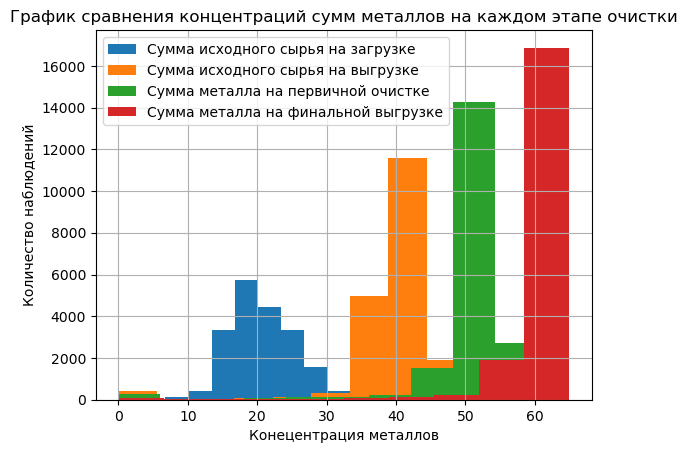

In [20]:
df_full['rougher_input_sum'].hist(label='Сумма исходного сырья на загрузке')
df_full['rougher_output_sum'].hist(label='Сумма исходного сырья на выгрузке')
df_full['primary_cleaner_sum'].hist(label='Сумма металла на первичной очистке')
df_full['final_output_sum'].hist(label='Сумма металла на финальной выгрузке')
plt.title('График сравнения концентраций сумм металлов на каждом этапе очистки')
plt.xlabel('Конецентрация металлов')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

На гистограмме мы видим распределение концентрации металлов после каждого этапа очистки. Так же мы видим выбросы.

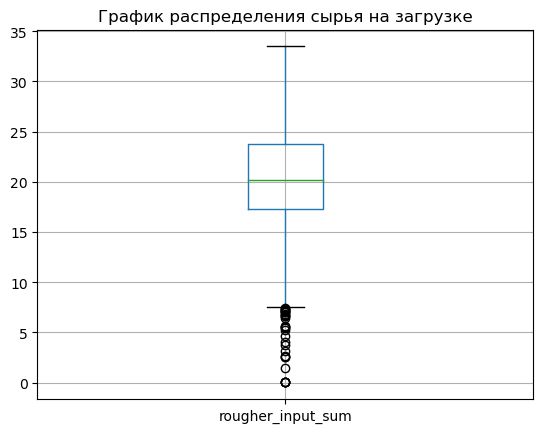

In [21]:
df_full.boxplot(column='rougher_input_sum') # посмотрим выбросы на ящике с усами
plt.title('График распределения сырья на загрузке')
plt.show()

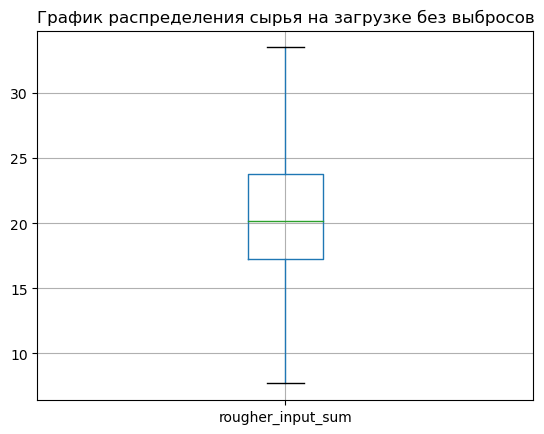

In [22]:
df_full.query('rougher_input_sum>7.6').boxplot(column='rougher_input_sum') # посмотрим выбросы на ящике с усами со срезом по выбросам
plt.title('График распределения сырья на загрузке без выбросов')
plt.show()

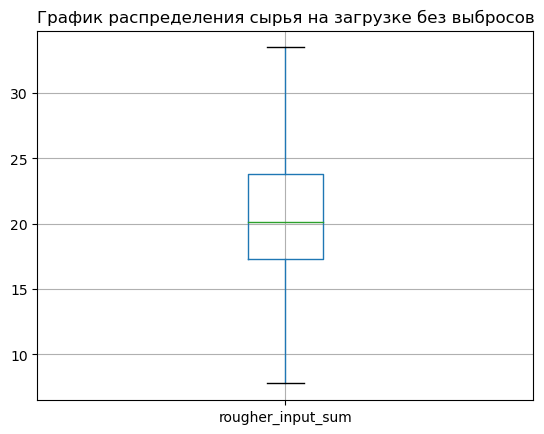

In [23]:
df_full_clear = df_full.loc[df_full['rougher_input_sum']>=7.7] # удалим выбросы
df_full_clear.boxplot(column='rougher_input_sum') # проверим
plt.title('График распределения сырья на загрузке без выбросов')
plt.show()

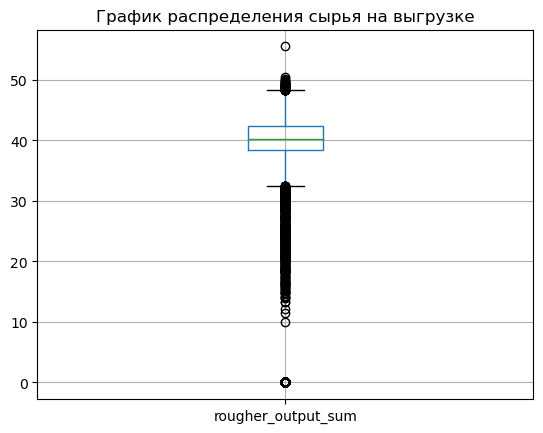

In [24]:
df_full_clear.boxplot(column='rougher_output_sum')
plt.title('График распределения сырья на выгрузке')
plt.show()

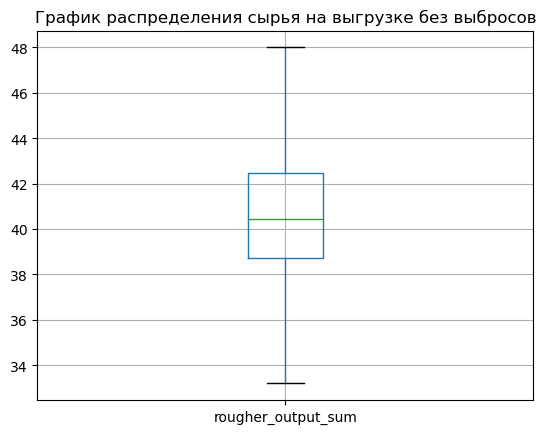

In [25]:
df_full_clear.query('rougher_output_sum>33.2 & rougher_output_sum<48').boxplot(column='rougher_output_sum')
plt.title('График распределения сырья на выгрузке без выбросов')
plt.show()

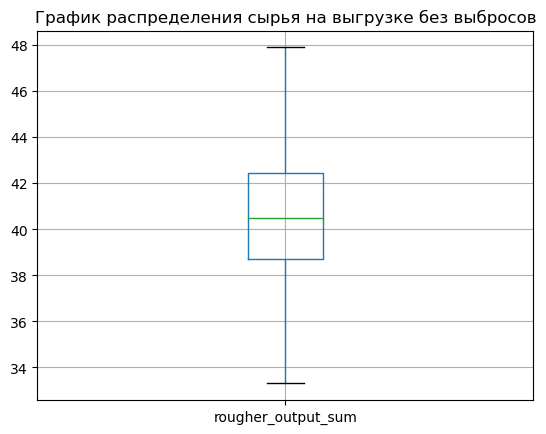

In [26]:
df_full_clear = df_full_clear.loc[df_full_clear['rougher_output_sum']>=33.3]
df_full_clear = df_full_clear.loc[df_full_clear['rougher_output_sum']<=47.9]
df_full_clear.boxplot(column='rougher_output_sum')
plt.title('График распределения сырья на выгрузке без выбросов')
plt.show()

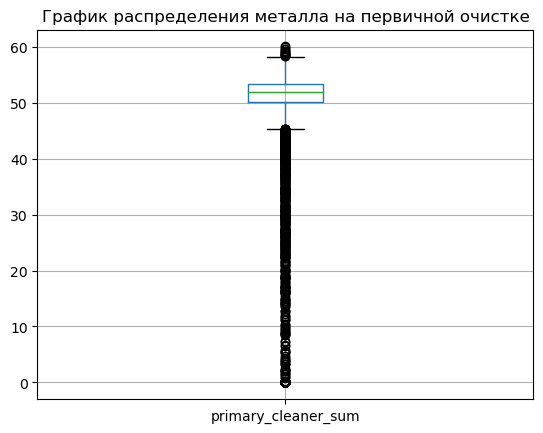

In [27]:
df_full_clear.boxplot(column='primary_cleaner_sum')
plt.title('График распределения металла на первичной очистке')
plt.show()

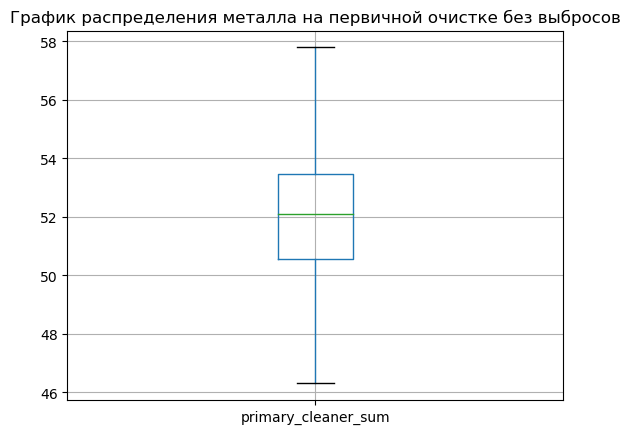

In [28]:
df_full_clear.query('primary_cleaner_sum>=46.3 & primary_cleaner_sum<=57.8').boxplot(column='primary_cleaner_sum')
plt.title('График распределения металла на первичной очистке без выбросов')
plt.show()

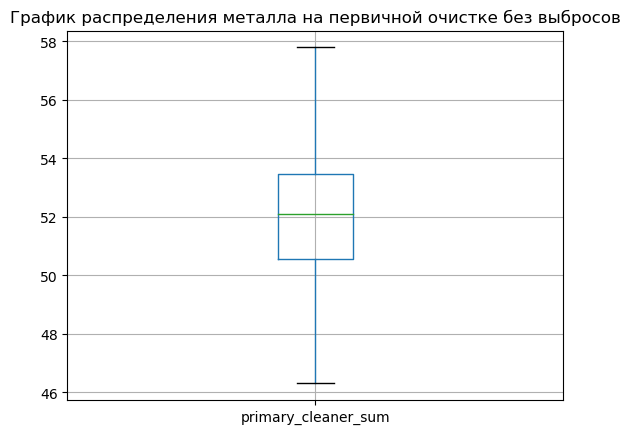

In [29]:
df_full_clear = df_full_clear.loc[df_full_clear['primary_cleaner_sum']>=46.3]
df_full_clear = df_full_clear.loc[df_full_clear['primary_cleaner_sum']<=57.8]
df_full_clear.boxplot(column='primary_cleaner_sum')
plt.title('График распределения металла на первичной очистке без выбросов')
plt.show()

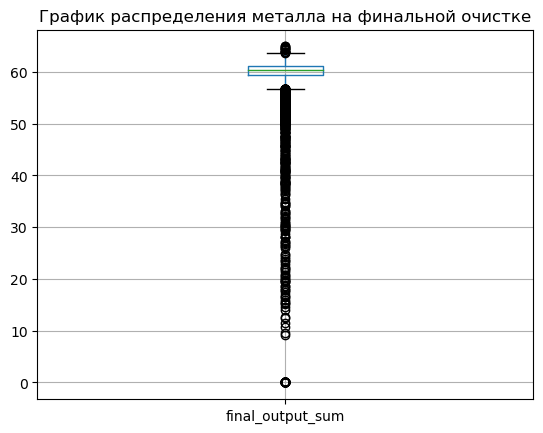

In [30]:
df_full_clear.boxplot(column='final_output_sum')
plt.title('График распределения металла на финальной очистке')
plt.show()

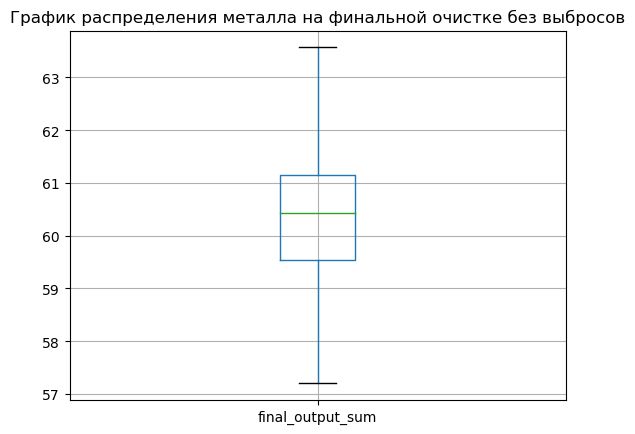

In [31]:
df_full_clear.query('final_output_sum>=57.2 & final_output_sum<=63.6').boxplot(column='final_output_sum')
plt.title('График распределения металла на финальной очистке без выбросов')
plt.show()

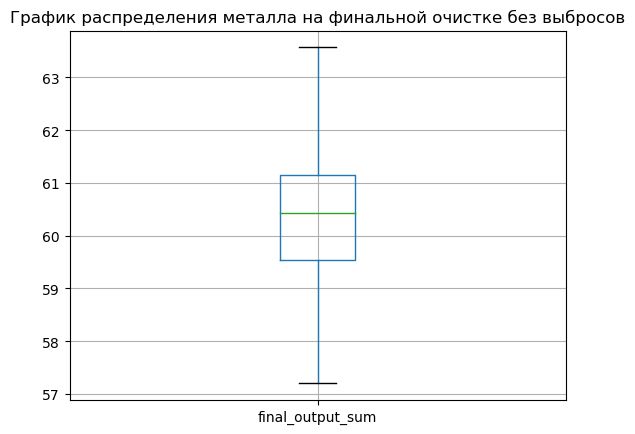

In [32]:
df_full_clear = df_full_clear.loc[df_full_clear['final_output_sum']>=57.2]
df_full_clear = df_full_clear.loc[df_full_clear['final_output_sum']<=63.6]
df_full_clear.boxplot(column='final_output_sum')
plt.title('График распределения металла на финальной очистке без выбросов')
plt.show()

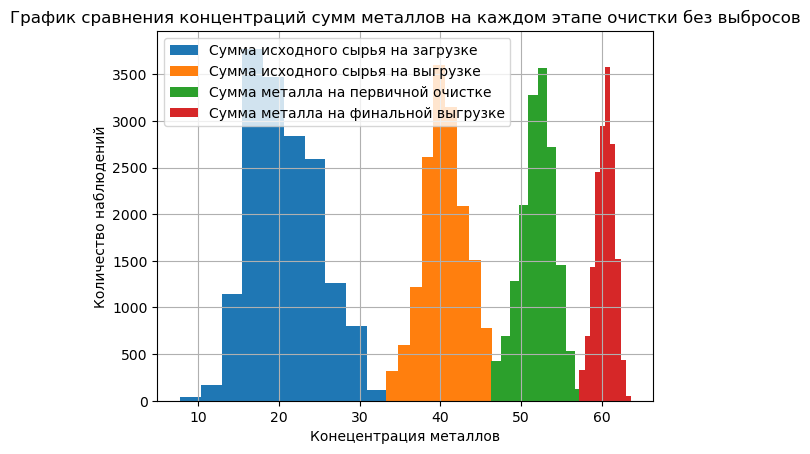

In [33]:
df_full_clear['rougher_input_sum'].hist(label='Сумма исходного сырья на загрузке')
df_full_clear['rougher_output_sum'].hist(label='Сумма исходного сырья на выгрузке')
df_full_clear['primary_cleaner_sum'].hist(label='Сумма металла на первичной очистке')
df_full_clear['final_output_sum'].hist(label='Сумма металла на финальной выгрузке')
plt.title('График сравнения концентраций сумм металлов на каждом этапе очистки без выбросов')
plt.xlabel('Конецентрация металлов')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

Мы удалили выбросы. На гистограмме мы видим распределение концентрации металлов после каждого этапа очистки. 

## Модель

### Напишем функцию для вычисления итоговой sMAPE.

In [34]:
def smape(a, f): 
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

### Обучим разные модели и оценим их качество кросс-валидацией.

Нужно спрогнозировать сразу две величины:
1) эффективность обогащения чернового концентрата rougher.output.recovery;

2) эффективность обогащения финального концентрата final.output.recovery.

Построим модель линейной регрессии

In [35]:
target = df_train['rougher.output.recovery']
features = df_train_new.drop(['date'], axis=1)                                         # в df_train_new столбец rougher.output.recovery мы удалили в предобработк

reg = Pipeline([                                                                       # зададим pipeline для последовательного применения действий
    ('impute', SimpleImputer(strategy='mean', add_indicator=False)),
    ('scale', StandardScaler()),
    ('linear', LinearRegression())
])

reg.fit(features, target)                                                              # обучим модель

smape_scorer = make_scorer(smape, greater_is_better=False)                             # используем кросс-валидацию
score = cross_val_score(reg, features, target, scoring=smape_scorer, cv=5).mean()      # найдем среднее значения скора по 5 выборками

abs(score)

13.781732828475336

Cимметричное среднее абсолютное процентное отклонение составляет 13.8% для модели линейной регрессии для целевого значения rougher.output.recovery после кросс-валидации

In [36]:
target = df_train['final.output.recovery']
features = df_train_new.drop(['date'], axis=1)                                         # в df_train_new столбец final.output.recovery мы удалили в предобработк

reg = Pipeline([                       
    ('impute', SimpleImputer(strategy='mean', add_indicator=False)),
    ('scale', StandardScaler()),
    ('linear', LinearRegression())
])

reg.fit(features, target)              

smape_scorer = make_scorer(smape, greater_is_better=False)         
score = cross_val_score(reg, features, target, scoring=smape_scorer, cv=5).mean()      

abs(score)

11.169089731769128

Cимметричное среднее абсолютное процентное отклонение составляет 11.2% для модели линейной регрессии для целевого значения final.output.recovery после кросс-валидации

In [37]:
final_smape = 0.25*13.8 + 0.75*11.2
final_smape

11.849999999999998

Итоговое значение sMAPE для валидационной выборки модели линейной регресси составляет 11.9%

Построим модель обучения для случайного леса

In [38]:
target = df_train['rougher.output.recovery']
features = df_train_new.drop(['date'], axis=1)

In [39]:
%%time
model = RandomForestRegressor(random_state=12345)

grid_space={'max_depth':[x for x in range(5,10,1)],          # модель GridSearch уже вклчает в себя кросс валидацию, поэтому ее не потрубется применять отдельно, просто возьмем лучшее значение
'n_estimators':[x for x in range(49,52,1)]
}

smape_scorer = make_scorer(smape, greater_is_better=False)

grid = GridSearchCV(model, scoring=smape_scorer, param_grid=grid_space , cv=3, n_jobs=-1)

grid.fit(features, target)

print('Лучшие гиперпараметры: '+str(grid.best_params_))
print('Лучший результат smape: '+str(grid.best_score_))

Лучшие гиперпараметры: {'max_depth': 5, 'n_estimators': 51}
Лучший результат smape: -13.60558403949395
CPU times: total: 12.4 s
Wall time: 46.3 s


Cимметричное среднее абсолютное процентное отклонение составляет 13.6% для модели случайного леса для целевого значения rougher.output.recovery

In [40]:
target = df_train['final.output.recovery']
features = df_train_new.drop(['date'], axis=1)

In [41]:
%%time
model = RandomForestRegressor(random_state=12345)

grid_space={'max_depth':[x for x in range(1,6,1)],          
'n_estimators':[x for x in range(35,40,1)]
}

smape_scorer = make_scorer(smape, greater_is_better=False)

grid = GridSearchCV(model, scoring=smape_scorer, param_grid=grid_space , cv=3, n_jobs=-1)

grid.fit(features, target)

print('Лучшие гиперпараметры: '+str(grid.best_params_))
print('Лучший результат smape: '+str(grid.best_score_))

Лучшие гиперпараметры: {'max_depth': 2, 'n_estimators': 36}
Лучший результат smape: -10.640760771105073
CPU times: total: 3.34 s
Wall time: 21.5 s


Cимметричное среднее абсолютное процентное отклонение составляет 10.6% для модели случайного леса для целевого значения final.output.recovery

In [42]:
final_smape = 0.25*13.6 + 0.75*10.6
final_smape

11.35

Итоговое значение sMAPE для валидационной выборки модели случайного леса составляет 11.4%

Мы построили 2 модели. Обе они показывают схожие значения. Случайный лес работает более точно, но линейная регрессия существенно быстрее. 

### Проверим лучшую модель на тестовой выборке.

Для того чтобы проверить модель на качество нам нужно знать истиные значения исходных данных. Но в df_test нет целевых значений. При этом в df_full все целевые значения есть.

Рассмотрим три файла. df_train составляет 14579 строк, df_test из 4860 строк, а df_full - 19439. Если сложить df_train и df_test то получиться так же 19439. Либо это невероятное совпадение, либо от df_full отделили какой то кусочек и назвали его df_test. Исходим из того что это не случайность и df_test это часть df_full. Значит в df_full содержатся истинные значения целевых параметров для которых мы считаем модели. 

Сравним выборки df_full и df_train.

In [43]:
df_full.head(14579) == df_train.head(14579)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,rougher_input_sum,rougher_output_sum,primary_cleaner_sum,final_output_sum
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14574,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
14575,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
14576,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
14577,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


На любом интервале в рамках длины всего размера df_train он полностью совпадает с df_full. Это говорит нам о том что df_test не случайная выборка а просто конец выборки df_full.

In [44]:
df_full_new = df_full.drop(col_list_difference, axis=1) # чтобы сравнить df_full и df_train уберем отличающиеся колонки

In [45]:
print(df_full_new.query('index>14578').describe()) # срез df_full полностью совпадает по числовым параметрам с df_train
df_test.describe()

       rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  \
count            4860.000000            4860.000000            4860.000000   
mean                8.005584               8.547348               3.561784   
std                 1.993590               1.958601               1.054072   
min                 0.010000               0.010000               0.010000   
25%                 6.574363               6.975898               2.889751   
50%                 7.812923               8.179714               3.534772   
75%                 9.556589              10.084339               4.193098   
max                13.417156              14.533698               7.142594   

       rougher.input.feed_sol  rougher.input.feed_rate  \
count             4860.000000              4860.000000   
mean                37.069792               490.309284   
std                  4.951534                94.390944   
min                  0.010000                 0.012786   
25%    

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,...,4.860000e+03,4860.000000,4.860000e+03,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000,4860.000000
mean,8.005584,8.547348,3.561784,37.069792,490.309284,59.136150,12.057597,6.101661,1108.613929,-368.367214,...,1.985651e+01,-488.677442,1.556951e+01,-464.194020,16.592772,-490.814830,12.944947,-489.585724,19.052445,-504.698207
std,1.993590,1.958601,1.054072,4.951534,94.390944,19.512497,3.409122,1.042937,156.484531,91.166106,...,5.913077e+00,44.396431,4.927123e+00,65.711575,5.724469,32.255136,5.533068,37.081098,5.549336,38.709553
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.889751,34.499634,434.099695,47.610795,9.891306,5.499815,999.716280,-499.732114,...,1.501081e+01,-500.705018,1.202130e+01,-500.196647,11.073147,-500.483408,9.011798,-500.129853,14.963797,-500.670150
50%,7.812923,8.179714,3.534772,37.477270,502.118742,55.461058,11.997874,6.099860,1001.415225,-300.181407,...,1.996782e+01,-499.893827,1.501236e+01,-499.541765,16.630479,-499.872663,11.999357,-499.955378,19.959824,-500.033782
75%,9.556589,10.084339,4.193098,40.450375,555.642707,66.538910,14.496080,6.802227,1202.826771,-299.961632,...,2.498898e+01,-498.652123,1.999938e+01,-400.302337,19.983130,-498.852661,15.003970,-499.643878,24.974535,-499.460505
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


In [46]:
df_test.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [47]:
df_full_new.query('index>14578').head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_input_sum,rougher_output_sum,primary_cleaner_sum,final_output_sum
14579,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575,14.399936,40.465768,49.544487,61.635645
14580,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,14.313448,40.148948,50.273714,61.401016
14581,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155,15.728505,40.864453,51.842596,61.515453
14582,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973,15.998448,41.125962,52.261084,61.091398
14583,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805,16.412815,40.769077,51.174693,60.900664


По распределению мы видим что они в точности совпадают. Таким образом мы можем точно получить истиные значения целевых параметров. 

In [48]:
target_test = df_full.query('index>14578')['rougher.output.recovery'] # определяем истиное значение для тестовой выборки для rougher.output.recovery

In [49]:
target = df_train['rougher.output.recovery']
features = df_train_new.drop(['date'], axis=1)

features_test = df_test.drop(['date'], axis=1)

model = RandomForestRegressor(max_depth=5, n_estimators=51, random_state=12345).fit(features, target)
predictions_valid = model.predict(features_test)

In [50]:
smape(predictions_valid,target_test)

5.128515452859511

Cимметричное среднее абсолютное процентное отклонение составляет 5.1% для модели случайного леса регрессии для целевого значения rougher.output.recovery на тестовой выборке.

In [51]:
target_test = df_full.query('index>14578')['final.output.recovery'] # определяем истиное значение для тестовой выборки для final.output.recovery

In [52]:
target = df_train['final.output.recovery']
features = df_train_new.drop(['date'], axis=1)

features_test = df_test.drop(['date'], axis=1)

model = RandomForestRegressor(max_depth=2, n_estimators=36, random_state=12345).fit(features, target)
predictions_valid = model.predict(features_test)

In [53]:
smape(predictions_valid,target_test)

8.692546782257528

Cимметричное среднее абсолютное процентное отклонение составляет 8.7% для модели случайного леса регрессии для целевого значения final.output.recovery на тестовой выборке.

In [54]:
final_smape = 0.25*5.1 + 0.75*8.7
final_smape

7.799999999999999

Итоговое sMAPE для тестовой выборки составляет 7.8%. 

Сравним результат нашей модели с моделью построенной Дамми.

In [55]:
target = df_train['rougher.output.recovery']
features = df_train_new.drop(['date'], axis=1)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
DummyRegressor()
dummy_regr_predict = dummy_regr.predict(features_test)
smape(dummy_regr_predict,target_test)

20.471182400274635

In [56]:
target = df_train['final.output.recovery']
features = df_train_new.drop(['date'], axis=1)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
DummyRegressor()
dummy_regr_predict = dummy_regr.predict(features_test)
smape(dummy_regr_predict,target_test)

9.407971043212596

In [57]:
final_smape = 0.25*20.5 + 0.75*9.4
final_smape

12.175

Результат Дамми Рергрессии 12.2%, а наш почти в 2 раза меньше. Это означает что мы получили результат в 2 раза лучше автоматической модели.

## Итоговый вывод:

Перед нами стояла задача подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Мы проделали следующие этапы:

1) Подготовка данных

Видим что некоторые данные имеют пропуски 10-100 значений. Самое большое количество пропусков в secondary_cleaner.output.tail_sol , примерно 1900 пропусков. 

Дата везде указана как строка а все остальные числовые данные в float64

Колонок у нас в обучающей и полной выборке по 87, а в тестовой 53. В описании указано что это связано с тем что в тестовой выборке удалены целевые значения. 

Проверили, что эффективность обогащения рассчитана правильно. Вычислили её на обучающей выборке для признака rougher.output.recovery. MAE между нашими расчётами и значением признака стремится к нулю.

Мы увидели, что отсутсвуют output — параметры продукта, а так же final — финальные характеристики и calculation — расчётные характеристики. Исходя из описания мы знаем, что это связано с тем, что часть данных еще не получили, а чать отсутсвует намеренно. 

Если говорить о построении модели обучения, то упомянутые выше параметры могут быть "спойлерами" для обучающей модели. Для получения более чистой модели мы должны удалить колонки в обучающей выборке, которы могут подсказывать верные варианты которые являются финальными и выявляются как промежуточные итоги.

Заполнили пропущенные данные и удалили колонки-спойлеры из тренировочной выборки. 

Определяем задачу построение модели обучения как поиск модели регрессии с учителем.

2) Анализ данных

А) Концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате выглядит следующим образом:

 - Гистограмма распределения наглядно показывает как меняется концентрация Au на различных этапах. С каждым последующим этапом очистки возрастает концентрация Au в сырье. Последний этап показывает наиболее наиболее сильное стремление к среднему значению. Так же отметим выбросы в 0 значении после певого этапа очистки и в финальном концентрате.
 - Гистограмма распределения наглядно показывает как меняется концентрация Ag на различных этапах. С каждым последующим этапом очистки меняется концентрация Ag в сырье. Последний этап показывает наиболее наиболее сильное стремление к среднему значению. Так же отметим выбросы в 0 значении на всех этапах очистки. При изменении сырья в черновой концентрат значение концентрации увеличилось что может говорить об удалении значительной части пустой породы, дальше концентрация падает на всех этапах что говорит о уменьшении Ag для более чистого значения Au
 - Гистограмма распределения наглядно показывает как меняется концентрация Pb на различных этапах. С каждым последующим этапом очистки меняется концентрация Pb в сырье. Последний этап показывает наиболее наиболее сильное стремление к среднему значению. Так же отметим выбросы в 0 значении на всех этапах очистки. С каждым этапом мы видим что увеличивается концентрация и увличивается стремление к среднему значению. 

Б) Сравнили распределение размеров гранул исходного сырья на обучающей и тестовой выборках

 - Гистограмма и метод описания указывает нам на то что гранулы распределены очень похожи образом в тестовой и тренировочной выборке. Существенные значения мы наблюдаем только в максимальных значениях, которые являются выбросами.
 
В) Исследовали суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате

 - Для Au мы видим что суммарная концентрация металла возрастает на каждом этапе очистки.
 - Для Ag мы видим общий тренд на убывание концентрации, но на черновом варианте она возрасла, верноятно это связи с большой убылью постой породы.
 - Для Pb мы видим что суммарная концентрация металла возрастает на каждом этапе очистки.
 
3) Построение модели

Написали функцию для вычисления итоговой sMAPE

Построили модель линейной регрессии

Cимметричное среднее абсолютное процентное отклонение составляет 13.8% для модели линейной регрессии для целевого значения rougher.output.recovery

Cимметричное среднее абсолютное процентное отклонение составляет 11.2% для модели линейной регрессии для целевого значения final.output.recovery

Итоговое значение sMAPE для валидационной выборки модели линейной регресси составляет 11.9%

Построили модель обучения для случайного леса

Cимметричное среднее абсолютное процентное отклонение составляет 13.6% для модели случайного леса регрессии для целевого значения rougher.output.recovery

Cимметричное среднее абсолютное процентное отклонение составляет 10.6% для модели случайного леса регрессии для целевого значения final.output.recovery

Итоговое значение sMAPE для валидационной выборки модели случайного леса регресси составляет 11.4%

Мы построили 2 модели. Обе они показывают схожие значения. Случайный лес работает более точно, но линейная регрессия существенно быстрее. 

4) Проверка на тестовой выборке

Мы опеределили target_test и проверили модель случайного леса на тестовой выборке.

Cимметричное среднее абсолютное процентное отклонение составляет 5.1% для модели случайного леса регрессии для целевого значения rougher.output.recovery на тестовой выборке.

Cимметричное среднее абсолютное процентное отклонение составляет 8.7% для модели случайного леса регрессии для целевого значения final.output.recovery на тестовой выборке.

Итоговое sMAPE для тестовой выборки составляет 7.8%.

Построенная Дамми модель показывает 12.2%. Наша модель машинного обучения показывает результат лучше.